## We're gonna count the topics of the sentences assigned to the n clusters

In [1]:
from sentence_transformers import SentenceTransformer

I1229 13:09:51.044848 139999523268416 file_utils.py:40] PyTorch version 1.1.0 available.


## load pretrained model

In [2]:
model = SentenceTransformer('bert-base-nli-mean-tokens')


I1229 13:09:54.511405 139999523268416 SentenceTransformer.py:29] Load pretrained SentenceTransformer: bert-base-nli-mean-tokens
I1229 13:09:54.514040 139999523268416 SentenceTransformer.py:32] Did not find a / or \ in the name. Assume to download model from server
I1229 13:09:54.618808 139999523268416 SentenceTransformer.py:68] Load SentenceTransformer from folder: /home/saul/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip
I1229 13:09:54.695612 139999523268416 configuration_utils.py:154] loading configuration file /home/saul/.cache/torch/sentence_transformers/public.ukp.informatik.tu-darmstadt.de_reimers_sentence-transformers_v0.2_bert-base-nli-mean-tokens.zip/0_BERT/config.json
I1229 13:09:54.720070 139999523268416 configuration_utils.py:174] Model config {
  "attention_probs_dropout_prob": 0.1,
  "finetuning_task": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,

In [64]:
import pandas as pd
from sklearn.manifold import TSNE
import re
from nltk.corpus import stopwords
import numpy as np
import matplotlib.pyplot as plt

In [40]:
#parameters
MIN = 1 ### Also for easy mapping from clean sentence to original sentence in df
STOPWORDS = True
SIZE = 10000
DIM = 1000

In [41]:
df = pd.read_csv('../data/reddit_batch1/batch.csv')

In [42]:
df = df.iloc[0:SIZE]

In [43]:
nn = df['topic'].unique().shape[0]

In [44]:
stop_words = set(stopwords.words('english'))


In [45]:
#for transformer
def clean_sen_trans(sent):
    clean_list = ''
    if STOPWORDS == True:
        for word in sent.split():
           # print(word)
            if word not in stop_words:
                word = re.sub('[\W_]+','',word)
                word = re.sub(' +', ' ', word)
                clean_list +=word.lower()+str(' ')
    else:
        for word in sent.split():
            word = re.sub('[\W_]+','',word)
            word = re.sub(' +', ' ', word)
            clean_list +=word.lower()+str(' ')

    return clean_list
    

In [46]:
pre1= []
for i in df.sentence:
    clean = clean_sen_trans(i)
    if len(clean) > MIN:
        pre1.append(clean)
       
    
    

In [47]:
len(pre1)

10000

In [48]:
embeddings = model.encode(pre1)

Batches: 100%|██████████| 1250/1250 [10:30<00:00,  2.13s/it]


In [49]:
queries=[]
for i in range(nn):
    queries.append(pre1[np.random.randint(0,len(pre1))])
print(queries)
query_embeddings = model.encode(queries)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

['kid part parents would say give real reason cry ', 'doubt professional archaeologist writes research interests include finding gold resume however another question get asked time fact excavating unit carefully dig squares circles tightly controlled levels like pealing back layers history passerbys almost always ask searching find gold fascination shiny valuable metal universal think nevertheless archaeology finding gold cool find often context small bead flake like elaborate gold cups masks see movies would argue though treasure consider fragment past whether broken ceramic arrowhead bone needle valuable piece past ', 'thank congrats best wishes february ', 'bad juju ', 'bee ftfy ', 'morelia patzcuaro lovely hope check uruapan back mexico shame situation parts guerrero hope things improve around mexico great place good luck peru ', 'earliest would guess lsd legal therapeutic settings ', 'really means heard parents say kid screaming hitting makes sense mom definitely trying say thank 

Batches: 100%|██████████| 1/1 [00:01<00:00,  1.53s/it]


In [50]:
import scipy.spatial
# Find the closest nn sentences of the corpus for each query sentence based on cosine similarity
closest_n = 5

for query, query_embedding in zip(queries, query_embeddings):
    distances = scipy.spatial.distance.cdist([query_embedding], embeddings, "cosine")[0]
    results = zip(range(len(distances)), distances)
    results = sorted(results, key=lambda x: x[1])

    for idx, distance in results[0:closest_n]:

       
        print(pre1[idx].strip(), 1-distance)


kid part parents would say give real reason cry 0.9999999999999999
really means heard parents say kid screaming hitting makes sense mom definitely trying say thank anything little shit 0.7852066151205668
kid going cry regardless least take chance learn lesson 0.784442743858913
idk love parents call kids assholes 0.7612920530967622
kid knew babies came 3 asked told comes every big deal one embarrassed think 7 little old know nothing also think teacher way base 0.74392893728614
doubt professional archaeologist writes research interests include finding gold resume however another question get asked time fact excavating unit carefully dig squares circles tightly controlled levels like pealing back layers history passerbys almost always ask searching find gold fascination shiny valuable metal universal think nevertheless archaeology finding gold cool find often context small bead flake like elaborate gold cups masks see movies would argue though treasure consider fragment past whether broke

In [51]:
from sklearn.cluster import KMeans
modelk = KMeans(n_clusters=nn, max_iter=1000, random_state=22, n_init=50).fit(X=embeddings)

In [61]:
clustered_sentences = [[] for i in range(nn)]
for sentence_id, cluster_id in enumerate(modelk.labels_):
    clustered_sentences[cluster_id].append(pre1[sentence_id])
freq_list=[]
for i, cluster in enumerate(clustered_sentences):
    freqs = {}

    for j in cluster:
       
        indx = pre1.index(j)
        topic = df.loc[indx].topic
        if not topic in freqs:
            freqs[topic] = 1
        else:
            freqs[topic] +=1

    freq_list.append(freqs)


In [87]:
def hist(freqs):
    i = 0
    for dic in freqs:
        plt.figure(figsize=(10,7))
        plt.bar(list(dic.keys()),dic.values())
        plt.xticks(fontsize=8)
        plt.title('Cluster '+str(i))
        plt.show()
        i +=1

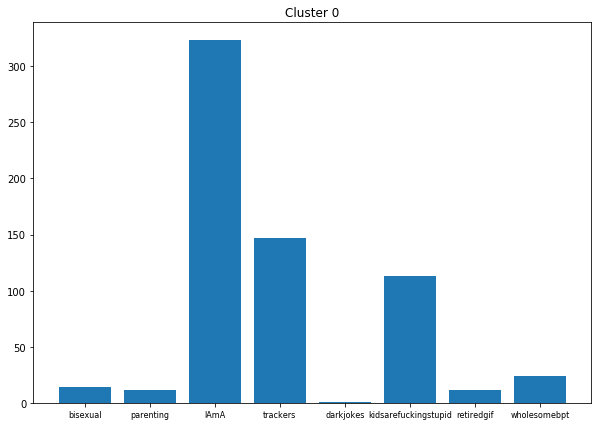

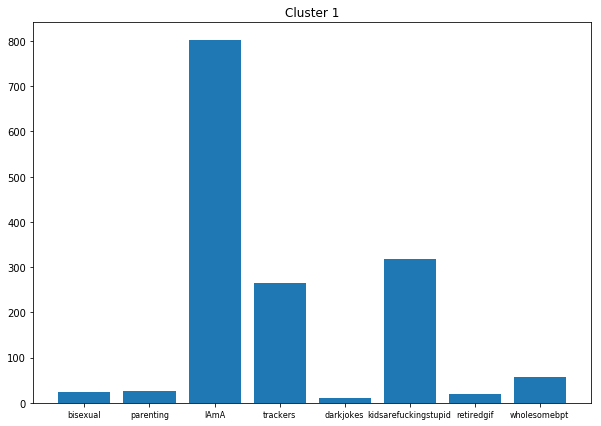

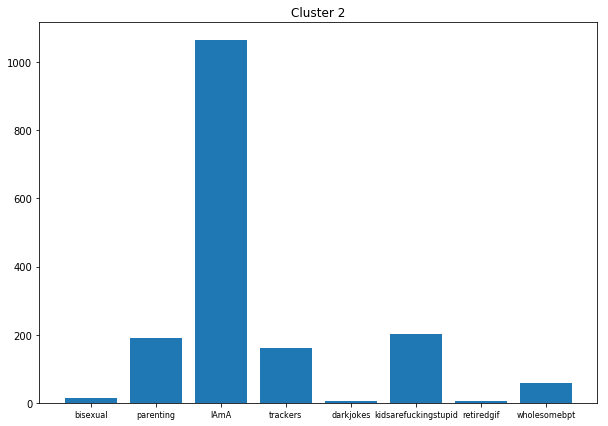

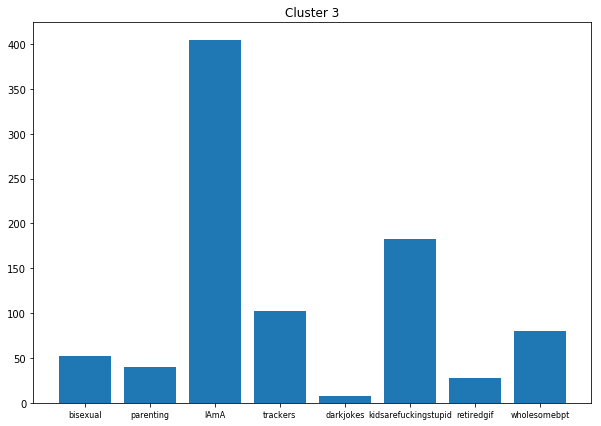

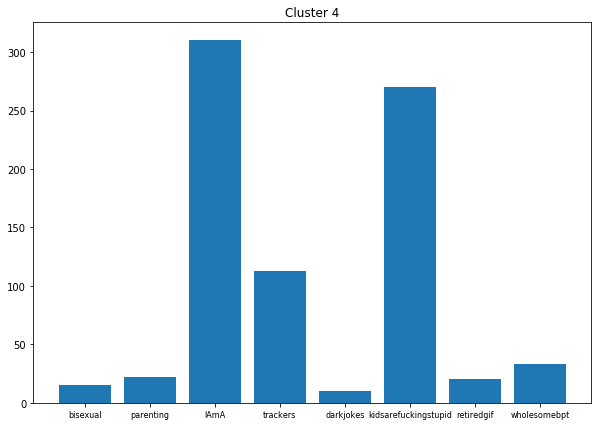

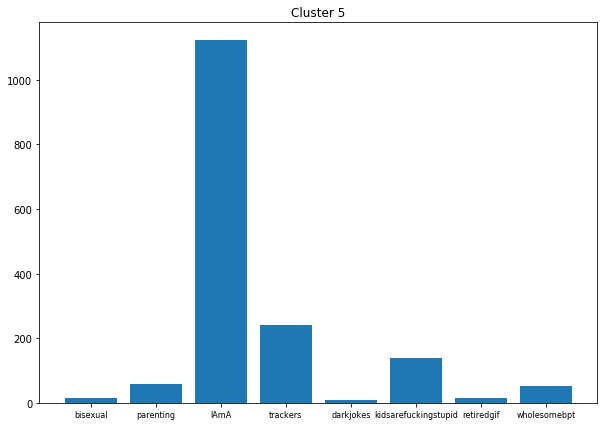

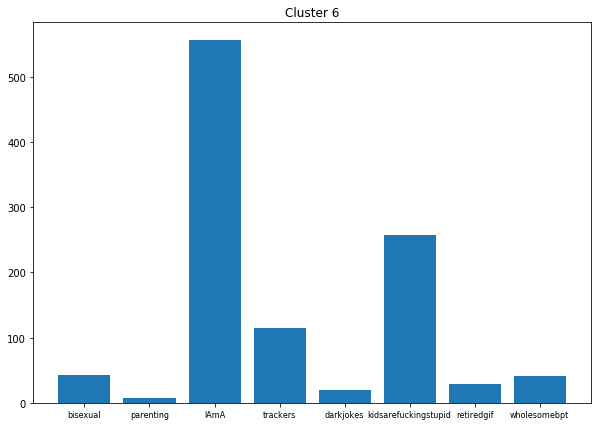

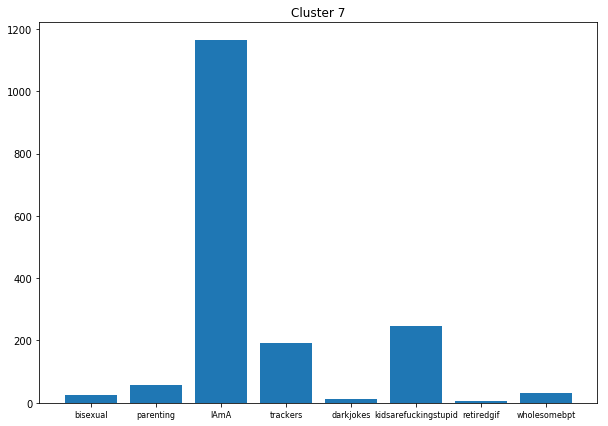

In [88]:
hist(freq_list)

In [195]:
top = closest_n

In [198]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

def plotsne(words,embs,perp):
    
    embs1 = np.array(embs).reshape(nn*top,768) ### reshape to nrandom*topn,DIM
    tsne_2d = TSNE(perplexity=perp, n_components=2, init='pca', n_iter=3500, random_state=32)
    emb_2d = np.array(tsne_2d.fit_transform(np.array(embs1)))    
    
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0,1,nn))
    
    j = 0
    jj = 0
    for clust in words:
        
        for i in clust:

            plt.annotate(i,xy=(emb_2d[j][0],emb_2d[j][1]),size=8,alpha=0.5)
       
            plt.scatter(emb_2d[j,0],emb_2d[j,1],alpha=0.8,c=colors[jj])
            j+=1
        jj += 1
    plt.show()

W1229 13:03:38.720323 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W1229 13:03:38.724195 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W1229 13:03:38.728368 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

W1229 13:03:38.881047 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W1229 13:03:38.886875 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W1229 13:03:38.896027 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

W1229 13:03:39.051040 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W1229 13:03:39.055166 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W1229 13:03:39.059682 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

W1229 13:03:39.182084 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W1229 13:03:39.187697 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W1229 13:03:39.193425 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

W1229 13:03:39.323438 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W1229 13:03:39.326882 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
W1229 13:03:39.330649 140082795939648 _axes.py:4217] 'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all 

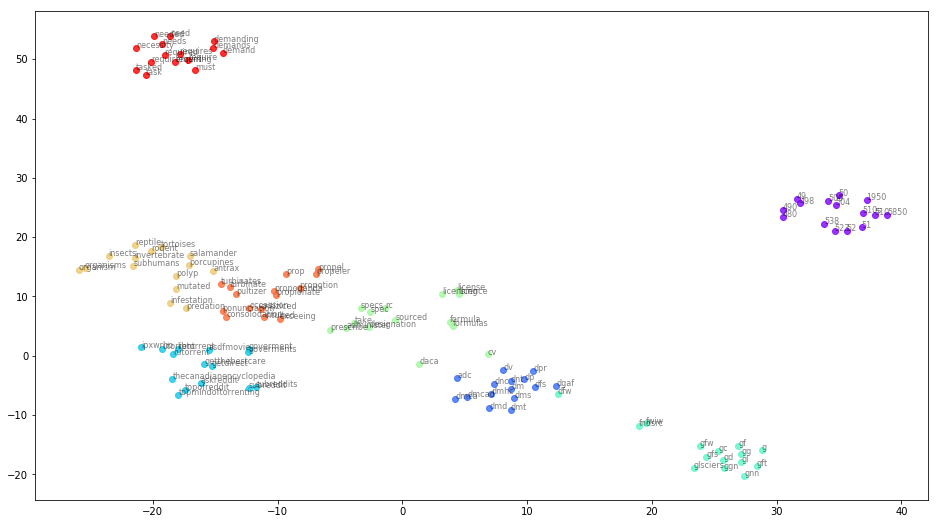

In [199]:
plotsne(words_cl,embs_cl,10)